In [13]:
import os
import sys
import time
import copy
import shutil
import random

import torch
import numpy as np
from tqdm import tqdm
import torch
import numpy as np
import pylab as plt
import torch.nn.functional as F
import torch.nn as nn
from torchinfo import summary
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.fft
from torch.nn.modules.container import Sequential
#from main_afnonet import get_args
from torch.utils.checkpoint import checkpoint_sequential
from torch.optim import Adam
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [14]:
#!conda install -c conda-forge cupy cudatoolkit=11.7

import cupy

In [15]:
from adacof import AdaCoFNet
model = AdaCoFNet()
checkpoint_path = '/home/hviswan/Hrishikesh-IDEAS/hviswan/NIO/adacof.pth'
print("loading checkpoint %s" % checkpoint_path)
checkpoint = torch.load(checkpoint_path)
model_dict = model.state_dict()
ckpt_dict = {}
mismatch = False

#print(dict(model_dict))
model_dict = dict(model_dict)
#print(checkpoint)
#break
#print(model_dict.keys())
#print(checkpoint['state_dict'].keys())
for k, v in checkpoint['state_dict'].items():
    k2 = k[0:]
    #print(k2)
    if k2 in model_dict:
        print(k2)
        if model_dict[k2].size() == v.size():
            ckpt_dict[k2] = v
        else:
            print("Size mismatch while loading! %s != %s Skipping %s..."%(str(model_dict[k2].size()), str(v.size()), k2))
            mismatch = True
    else:
        print("Model Dict not in Saved Dict! %s != %s Skipping %s..."%(2, str(v.size()), k2))
        mismatch = True
if len(model.state_dict().keys()) > len(ckpt_dict.keys()):
    mismatch = True
model_dict.update(ckpt_dict)
model.load_state_dict(model_dict)
model_dict = dict(model.state_dict())

for k, v in checkpoint['state_dict'].items():
    print(torch.eq(v.cuda(), model_dict[k[0:]].cuda()))

model = model.cuda()
model.eval()
print("Loaded Checkpoint")

loading checkpoint /home/hviswan/Hrishikesh-IDEAS/hviswan/NIO/adacof.pth
get_kernel.moduleConv1.0.weight
get_kernel.moduleConv1.0.bias
get_kernel.moduleConv1.2.weight
get_kernel.moduleConv1.2.bias
get_kernel.moduleConv1.4.weight
get_kernel.moduleConv1.4.bias
get_kernel.moduleConv2.0.weight
get_kernel.moduleConv2.0.bias
get_kernel.moduleConv2.2.weight
get_kernel.moduleConv2.2.bias
get_kernel.moduleConv2.4.weight
get_kernel.moduleConv2.4.bias
get_kernel.moduleConv3.0.weight
get_kernel.moduleConv3.0.bias
get_kernel.moduleConv3.2.weight
get_kernel.moduleConv3.2.bias
get_kernel.moduleConv3.4.weight
get_kernel.moduleConv3.4.bias
get_kernel.moduleConv4.0.weight
get_kernel.moduleConv4.0.bias
get_kernel.moduleConv4.2.weight
get_kernel.moduleConv4.2.bias
get_kernel.moduleConv4.4.weight
get_kernel.moduleConv4.4.bias
get_kernel.moduleConv5.0.weight
get_kernel.moduleConv5.0.bias
get_kernel.moduleConv5.2.weight
get_kernel.moduleConv5.2.bias
get_kernel.moduleConv5.4.weight
get_kernel.moduleConv5.4.bi

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         ...,

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         ...,

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, T

In [16]:
tensor_rand = torch.rand((10,3,854,480)).cuda()
tensor_rand2 = torch.rand((10,3,854,480)).cuda()
print(tensor_rand.shape)
out = model(tensor_rand, tensor_rand2)
print(out.shape)

torch.Size([10, 3, 854, 480])
torch.Size([10, 3, 854, 480])


In [20]:
sys.path.append('/home/hviswan/Hrishikesh-IDEAS/hviswan/NIO')
from NIO import NIO

#from CAIN_encdec import CAIN as CAIN
#from VFIT_S import UNet_3D_3D

from NIO_transformer import NIO_transformer

class CAIN_NIO(nn.Module):
    def __init__(self, img_size=(224, 224), patch_size=(16, 16), in_chans=3, embed_dim=768):
        super().__init__()
        #self.adacofLayer = model
        #self.CAIN_base_layer = CAIN(depth=3)
        self.NIO_base_layer = NIO(3,3)
        #self.NIO_base_layer = NIO_transformer(img_size=(256,256))
    def forward(self, x):
        #self.adacofLayer.eval()
        x_l = x[0]
        x_r = x[1]
        #adacof_out = self.adacofLayer(x_l, x_r).cuda()
        #x = torch.stack((x_l, x_r))
        NIO_out = self.NIO_base_layer(x)
        #print(x_l.shape)
        #print(x_r.shape)
        #cain_out, cain_feats = self.CAIN_base_layer(x_l, x_r)
        #x_out = torch.nn.functional.interpolate(cain_out, size = (x_l.shape[2], x_l.shape[3]),mode = 'bicubic',align_corners=True)
        #print("CAIN SHAPE = ", cain_out.shape)
        #print(cain_out.shape)
        #model_out = self.NIO_base_layer(cain_out)
        #print(model_out.shape)
        return NIO_out
    
#NIO_base = NIO_single(3,3)
#CAIN_base = CAIN_EncDec(depth=3, start_filts=32)
#NIO_base = NIO(3,3).cuda()
#NIO_base.eval()
NIO_model = CAIN_NIO().cuda()
#summary(NIO_model, input_size=(2, 10,100,100,3))
#summary(CAIN_base, input_size=[(32,3,100,100),(32,3,100,100)])
#optimizer = Adam(NIO_model.parameters(), lr=1e-3, betas=(0.9, 0.99))
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
#CAIN_weights = torch.load('/home/hviswan/Hrishikesh-IDEAS/hviswan/NIO/pretrained_cain.pth')
#print(CAIN_model)
#input1 = torch.rand((10,3,256,256)).cuda()
#input2 = torch.rand((10,3,256,256)).cuda()
#CAIN_model = CAIN()
#Adacof = AdaCoFNet().cuda()
#Adacof.eval()
#cain_out = Adacof(input1, input2)
#print(cain_out.shape)
summary(NIO_model, input_size=(2,10,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
CAIN_NIO                                 [10, 3, 256, 256]         --
├─NIO: 1-1                               [10, 3, 256, 256]         --
│    └─Conv2d: 2-4                       [10, 3, 256, 256]         (recursive)
│    └─UNO: 2-2                          [10, 3, 256, 256]         14,212,882
│    │    └─Conv2d: 3-1                  [10, 3, 256, 256]         12
│    │    └─Conv2d: 3-2                  [10, 3, 256, 256]         (recursive)
│    │    └─Linear: 3-3                  [10, 256, 256, 3]         12
│    │    └─SpectralConv2d: 3-4          [10, 48, 256, 256]        294,912
│    │    └─pointwise_op: 3-5            [10, 48, 256, 256]        192
│    │    └─SpectralConv2d: 3-6          [10, 96, 128, 128]        6,230,016
│    │    └─pointwise_op: 3-7            [10, 96, 128, 128]        4,704
│    │    └─SpectralConv2d: 3-8          [10, 192, 64, 64]         6,230,016
│    │    └─pointwise_op: 3-9       

In [21]:
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
import random
def LoadDataBatches(batchNumber, batches=4, isNormalized=True, isTrain=True, percent=1):
    if(isTrain):
        x_train = torch.load('/scratch/gilbreth/hviswan/x_train_vimeo_256_diff_type.pt')
        y_train = torch.load('/scratch/gilbreth/hviswan/y_train_vimeo_256_diff_type.pt')
        

        ntrain = x_train.shape[0]
        
        ntrain_slice = int(ntrain*percent)
        if(ntrain_slice < ntrain-30):
            start_index = min(0, random.randint(0, ntrain-ntrain_slice-30))
        else:
            start_index = 0
        x_train = x_train[0+start_index:start_index+ntrain_slice]
        x_train = torch.permute(x_train, (1, 0,2,3,4))
        print(x_train.shape)
        #ntrain = x_train.shape[1]
        y_train = y_train.reshape(ntrain, x_train.shape[2], x_train.shape[3], x_train.shape[4])
        y_train = y_train[0+start_index:ntrain_slice+start_index]
        print(x_train.shape)
        print(y_train.shape)
        if(isNormalized):
            y_normalizer = MinMaxNormalizer(y_train)
            x_normalizer = MinMaxNormalizer(x_train)
            x_train = x_normalizer.encode(x_train)
            y_train = y_normalizer.encode(y_train)
        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train[0], x_train[1], y_train), batch_size=batches, shuffle=True)
        if(isNormalized):
            return train_loader, y_normalizer
        return train_loader
    else:
        #x_test = torch.load('/scratch/gilbreth/hviswan/x_test_vimeo_256_diff_type.pt')
        #y_test = torch.load('/scratch/gilbreth/hviswan/y_test_vimeo_256_diff_type.pt')
        x_test = torch.load('/scratch/gilbreth/hviswan/Tests/testx_480.pt')
        y_test = torch.load('/scratch/gilbreth/hviswan/Tests/testy_480.pt')
        ntest = x_test.shape[0]
        #x_test = x_test[0: 500]
        x_test = torch.permute(x_test, (1, 0,2,3,4))
        
        y_test = y_test.reshape(ntest, x_test.shape[2], x_test.shape[3], x_test.shape[4])
        #y_test = y_test[0:500]
        print(x_test.shape)
        print(y_test.shape)
        if(isNormalized):
            y_normalizer = MinMaxNormalizer(y_test)
            x_normalizer = MinMaxNormalizer(x_test)
            x_test = x_normalizer.encode(x_test)
            y_test = y_normalizer.encode(y_test)
        test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test[0], x_test[1], y_test), batch_size=batches, shuffle=True)
        if(isNormalized):
            return test_loader, y_normalizer
        return test_loader
#LoadDataBatches(2, batches=10, isNormalized=False, percent=1)
#LoadDataBatches(2, batches=10, isNormalized=False, percent=1, isTrain=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class MeanShift(nn.Conv2d):
    def __init__(self, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False

class VGG(nn.Module):
    def __init__(self, loss_type):
        super(VGG, self).__init__()
        vgg_features = models.vgg19(pretrained=True).features
        modules = [m.cuda() for m in vgg_features]
        conv_index = loss_type
        if conv_index == '22':
            self.vgg = nn.Sequential(*modules[:8])
        elif conv_index == '33':
            self.vgg = nn.Sequential(*modules[:16])
        elif conv_index == '44':
            self.vgg = nn.Sequential(*modules[:26])
        elif conv_index == '54':
            self.vgg = nn.Sequential(*modules[:35])
        elif conv_index == 'P':
            self.vgg = nn.ModuleList([
                nn.Sequential(*modules[:8]),
                nn.Sequential(*modules[8:16]),
                nn.Sequential(*modules[16:26]),
                nn.Sequential(*modules[26:35])
            ])
        self.vgg = nn.DataParallel(self.vgg).cuda()

        vgg_mean = (0.485, 0.456, 0.406)
        vgg_std = (0.229, 0.224, 0.225)
        self.sub_mean = MeanShift(vgg_mean, vgg_std)
        self.vgg.requires_grad = False
        # self.criterion = nn.L1Loss()
        self.conv_index = conv_index

    def forward(self, sr, hr):
        def _forward(x):
            x = x.cpu()
            x = self.sub_mean(x)
            x = self.vgg(x)
            return x.cuda()
        def _forward_all(x):
            feats = []
            x = x.cpu()
            x = self.sub_mean(x)
            for module in self.vgg.module:
                x = module(x.cuda())
                feats.append(x.cuda())
            return feats

        if self.conv_index == 'P':
            vgg_sr_feats = _forward_all(sr)
            with torch.no_grad():
                vgg_hr_feats = _forward_all(hr.detach())
            loss = 0
            for i in range(len(vgg_sr_feats)):
                loss_f = F.mse_loss(vgg_sr_feats[i], vgg_hr_feats[i])
                #print(loss_f)
                loss += loss_f
            #print()
        else:
            vgg_sr = _forward(sr)
            with torch.no_grad():
                vgg_hr = _forward(hr.detach())
            loss = F.mse_loss(vgg_sr, vgg_hr)

        return loss

In [ ]:
from datetime import datetime as time
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as FF
import cv2
import PIL
from loss import Loss
import matplotlib.pyplot as plt
myloss = torch.nn.MSELoss()
l1loss = torch.nn.L1Loss()
kldivloss = torch.nn.KLDivLoss()

criterion = Loss('1*L1')
vggloss = VGG('22')
RHO = 0.05
BETA = 0.01
def train(D, G, train_data, epochs, D_optim, G_optim, scheduler=None):
    losses_D = np.zeros(epochs)
    losses_G = np.zeros(epochs)
    ssims_G = np.zeros(epochs)
    train_data = LoadDataBatches(0, isNormalized=False, batches=2, isTrain=True)
    validation_data = LoadDataBatches(0, isNormalized=False, batches=2, isTrain=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(G_optim, factor=0.2, patience=5, mode='min')
    criterion.train()
    #train_counter = 0
    print_counter = 0
    for i in range(231, epochs+1):
        t1 = time.now()
        loss_D = 0.0
        loss_G = 0.0
        ssim_G = 0.0
        train_counter = 0
        ssim_batch=0
        for j in range(1):
            for xl,xr,y in train_data:
                train_counter += 1
                temp = 0.05*xl + 0.1*xr
                #xl = xl.permute(0,3,1,2)
                #xr = xr.permute(0,3,1,2)
                x_l = xl.cuda()
                x_r = xr.cuda()
                #xl = xl.cpu().detach().numpy()
                #y = y.cpu().detach().numpy()
                #xr = xr.cpu().detach().numpy()
                
                #x = torch.from_numpy(np.asarray([xl,xr]).astype(np.float32))
                adacof_out = model(x_l, x_r)
                
                y = y.cuda()
                #x = x.cuda()
                #G_optim.zero_grad()
                x = torch.stack((adacof_out, adacof_out))
                #x_syn = NIO_base(x)
                #x = torch.stack((x_syn, x_syn))
                x_syn = G(x)
                #print(x_syn.shape)
                """
                if(print_counter<10):
                    x_out = x_syn.permute(0,2,3,1)
                    x_out = x_out.cpu().detach().numpy()
                    #y_out = y.permute(0,3,1,2)
                    y_out = y.cpu().detach().numpy()
                    plt.imshow(x_out[0].astype('uint8'))
                    plt.show()
                    plt.imshow(y_out[0].astype('uint8'))
                    plt.show()
                print_counter+=1
                """
                y2 = torch.permute(y, (0, 2, 3,1)).type(torch.float32)
                #print("X_syn = ", x_syn.shape)
                #print("y = ", y.shape)
                #print("y2 = ", y2.shape)
                x_syn2 = torch.permute(x_syn, (0, 2, 3, 1))
                #y = xr.reshape(xr.shape[0], xr.shape[1],xr.shape[2],xr.shape[3])
                #loss, loss_specific = criterion(x_syn, y2, None)
                #print("X Shape = ", x.shape)
                #print("X_syn = ", x_syn.shape)
                #print("Y2 = ", y2.shape)
                #print(y.shape)
                #print(x_syn.shape)
                W_loss = l1loss(x_syn.type(torch.float32), y.type(torch.float32)) #+ 0.001*vggloss(x_syn.type(torch.float32), y.type(torch.float32))#+ 0.01*torch.abs(kldivloss(x_syn2.type(torch.float32), y2.type(torch.float32)))
                #ssim_value = W_loss.item()
                ssim_individual = 0.0
                for k in range(y.shape[0]):
                    ssim_individual += ssim(x_syn2[k].detach().cpu().numpy(), y2[k].detach().cpu().numpy(), multichannel=True)
                
                ssim_batch += ssim_individual/y.shape[0]
                loss = W_loss
                loss.backward()
                loss_G += loss.item() 
                #torch.nn.utils.clip_grad_norm_(G.parameters(), 0.1)
                G_optim.step()
                if(train_counter %150 == 0 or train_counter == 1):
                    print("Batch = ",train_counter," Train Loss = ", loss_G/train_counter, " SSIM = ", ssim_batch/(train_counter))
            losses_D[i] = loss_D / train_counter
            losses_G[i] = loss_G / train_counter
            ssims_G[i] = ssim_batch / train_counter
            t2 = time.now()
            test_counter = 1
            """
            test_counter = 0
            ssim_batch = 0
            for xl, xr, y in validation_data:
                temp = 0.05*xl + 0.1*xr
                xl = xl.cpu().detach().numpy()
                xr = xr.cpu().detach().numpy()
                x = torch.from_numpy(np.asarray([xl,xr]).astype(np.float32))
                x = x.cuda()
                y = y.cuda()
                x_syn = G(x).cuda()
                x_syn = x_syn + temp.cuda()
                x_syn = y_normalizer_test.decode(x_syn)
                y = y_normalizer_test.decode(y)
                x_syn2 = torch.permute(x_syn, (0, 3, 1, 2)).type(torch.float32)
                y2 = torch.permute(y, (0, 3, 1,2)).type(torch.float32)
                y = y.reshape(y.shape[0], y.shape[1],y.shape[2],y.shape[3])
                W_loss = huberloss(x_syn2.type(torch.float32), y2.type(torch.float32))*10000
                ssim_individual = 0.0
                for k in range(y.shape[0]):
                    ssim_individual += ssim(x_syn[k].detach().cpu().numpy(), y[k].detach().cpu().numpy(), multichannel=True)
                
                ssim_batch += ssim_individual/y.shape[0]
                loss = W_loss
                loss.backward()
                G_optim.step()
                loss_D += loss.item()
                test_counter += 1
                if(test_counter %50 == 0 or test_counter == 1):
                    print("Batch = ",test_counter," Validation Loss = ", loss_D/test_counter, " SSIM = ", ssim_batch/(test_counter))
            losses_D[i] = loss_D/test_counter
            """
            print("Loader #: ", j, " Epoch: ", i, "/ ",epochs," -  Time: ", t2-t1, "s - Validation Loss: ", losses_D[i], " - Train Loss: ", losses_G[i], " - train SSIM: ", ssims_G[i], " validation SSIM: ", ssim_batch/test_counter)
        if(i%10 == 0):
            torch.save(G, '/depot/bera89/data/hviswan/CAIN_AFNO'+str(i)+'.pt')
            
    return losses_D, losses_G, D, G

In [ ]:
device = 'cuda:11'
epochs=2000
#G = torch.load('/depot/bera89/data/hviswan/CAIN_NIO100.pt')
NIO_model = torch.load('/depot/bera89/data/hviswan/CAIN_AFNO180.pt')
optimizer = Adam(NIO_model.parameters(), lr=1e-3, betas=(0.9, 0.99))
losses_D, losses_G, D, G = train(None, NIO_model, None, epochs, None, optimizer)

/tmp/ipykernel_163227/1497703512.py:44: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_individual += ssim(x2[k].detach().cpu().numpy(), y2[k].detach().cpu().numpy(), multichannel=True)
/tmp/ipykernel_163227/1497703512.py:45: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_individual_ada += ssim(ada2[k].detach().cpu().numpy(), y2[k].detach().cpu().numpy(), multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 7, 3, 480, 854])
torch.Size([7, 3, 480, 854])
0.0041397949680686 0.00413716584444046
0.0
0.9969013333320618 0.9969012141227722


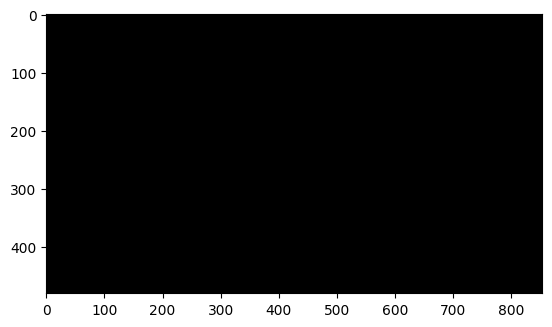

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


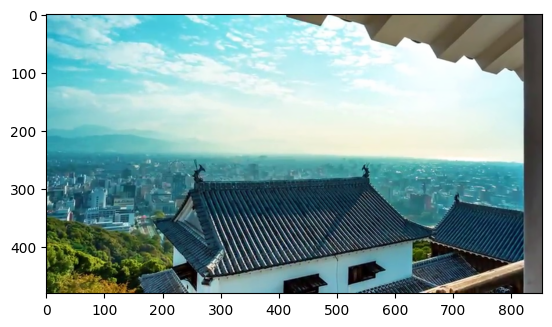

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


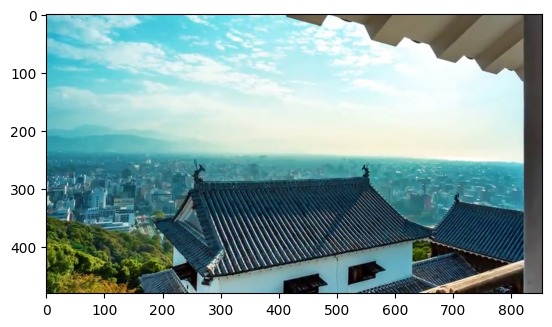

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0050049410201609135 0.005002621561288834
0.0
0.9939171671867371 0.9939168095588684


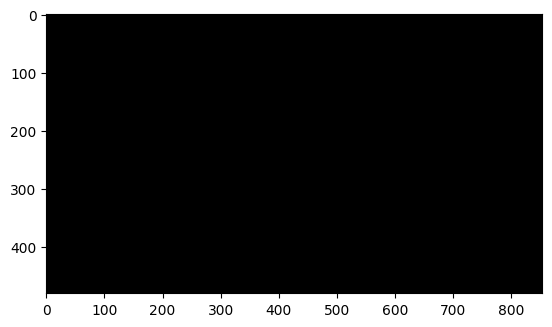

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


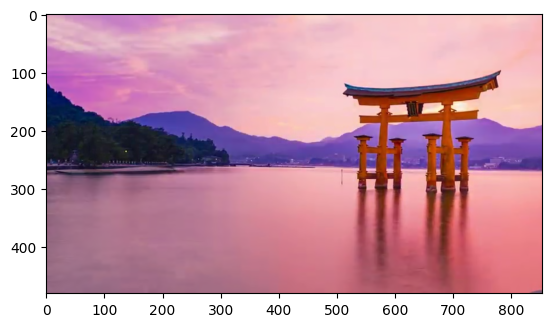

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


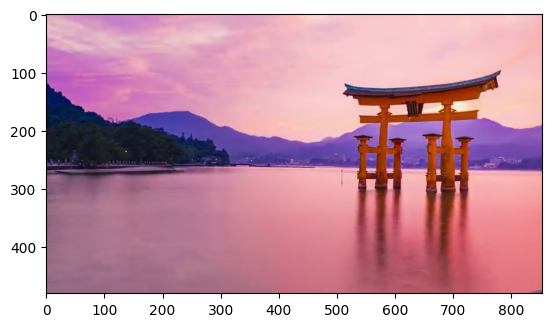

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.014758237637579441 0.01475139893591404
0.0
0.9724466800689697 0.9724528193473816


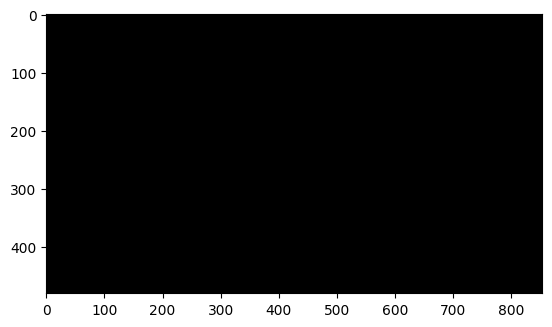

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


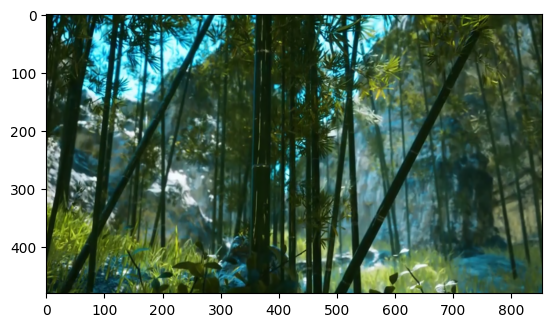

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


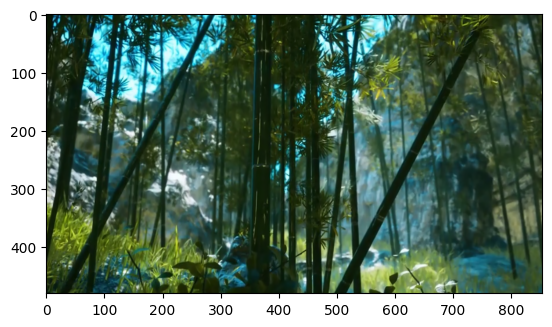

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.016288405284285545 0.016290124505758286
0.0
0.9601168632507324 0.9601127505302429


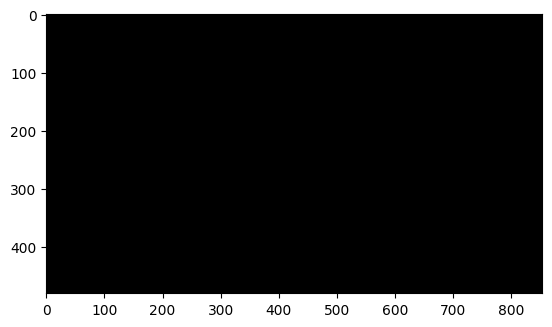

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


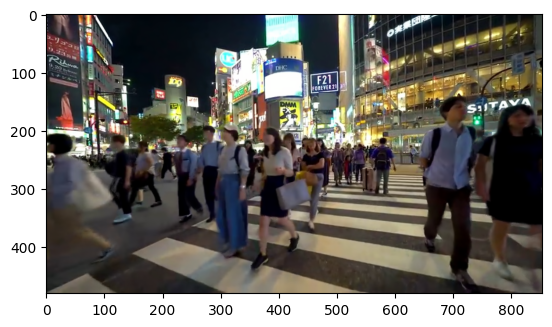

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


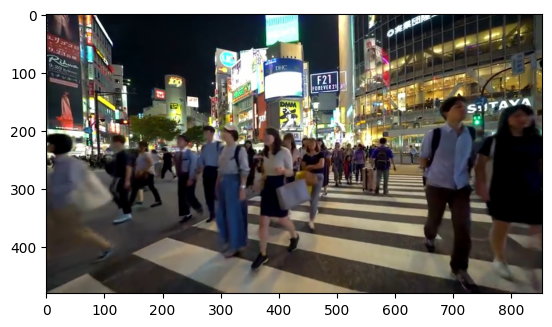

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00625875499099493 0.006263538729399443
0.0
0.991990327835083 0.9919828772544861


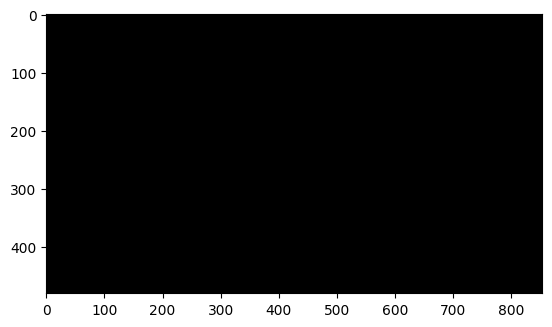

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


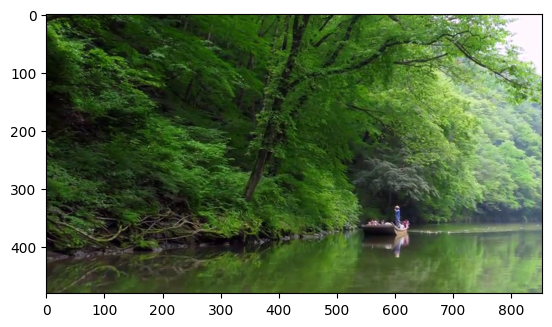

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


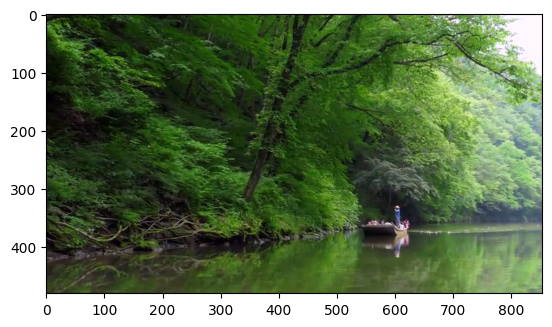

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.007534678094089031 0.00753164105117321
0.0
0.9911518692970276 0.991152286529541


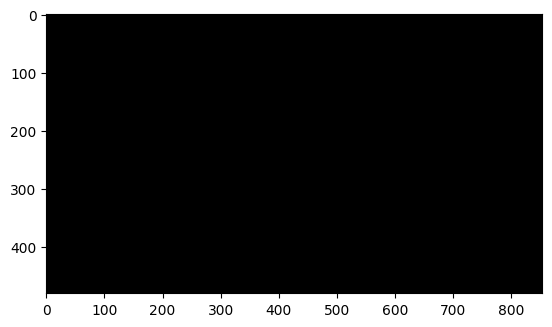

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


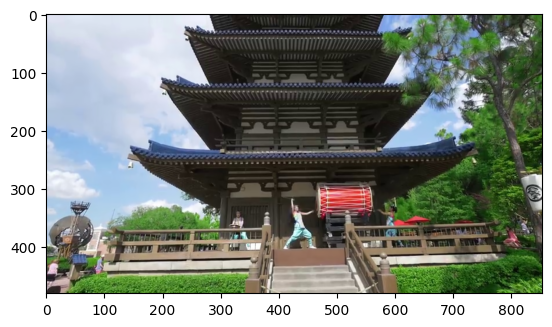

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


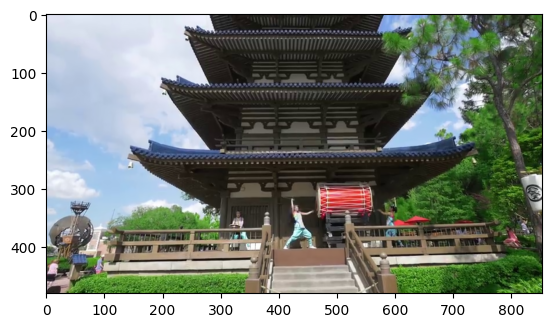

0.9844207068284353 0.9844197928905487
0.0


In [22]:
from math import log10, sqrt
import cv2
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

NIO_model = torch.load('/depot/bera89/data/hviswan/CAIN_AFNO620.pt')
NIO_model.eval()
l1loss = torch.nn.L1Loss()
import matplotlib.pyplot as plt
counter = 0
overall_counter = 0
train_data = LoadDataBatches(0, isNormalized=False, batches=1, isTrain=False)
ssim_batch = 0.0
ssim_batch_ada = 0.0
psnr_batch = 0.0
index = 0
for xl, xr, y in train_data:
    if index == 0:
        index+=1
        continue
    xl = xl.cuda()
    xr = xr.cuda()
    y = y.cuda()
    adacof_out = model(xl, xr)
    x = torch.stack((adacof_out, adacof_out))
    model_out = NIO_model(x)
    W_loss = l1loss(model_out.type(torch.float32), y.type(torch.float32))
    W_loss2 = l1loss(adacof_out.type(torch.float32), y.type(torch.float32))
    print(W_loss.item(), W_loss2.item())
    x2 = torch.permute(model_out, (0,2,3,1))
    ada2 = torch.permute(adacof_out, (0,2,3,1))
    y2 = torch.permute(y, (0,2,3,1))
    ssim_individual = 0.0
    psnr_ind = 0.0
    ssim_individual_ada = 0.0
    
    for k in range(x2.shape[0]):
        ssim_individual += ssim(x2[k].detach().cpu().numpy(), y2[k].detach().cpu().numpy(), multichannel=True)
        ssim_individual_ada += ssim(ada2[k].detach().cpu().numpy(), y2[k].detach().cpu().numpy(), multichannel=True)
        #psnr_ind += psnr(y2[k].detach().cpu().numpy().astype(np.float64)/255.0, ada2[k].detach().cpu().numpy().astype(np.float64)/255.0)
    print(psnr_ind/x2.shape[0])
    print(ssim_individual/x2.shape[0], ssim_individual_ada/x2.shape[0])
    ssim_batch += ssim_individual/x2.shape[0]
    ssim_batch_ada += ssim_individual_ada/x2.shape[0]
    psnr_batch += psnr_ind/x2.shape[0]
    counter += 1
    overall_counter+=1
    if(counter<=20):
        model_out = torch.permute(model_out, (0, 2,3,1))
        model_out = model_out.detach().cpu().numpy()
        adacof_out = torch.permute(adacof_out, (0,2,3,1))
        adacof_out = adacof_out.detach().cpu().numpy()
        difference = cv2.subtract(model_out[0], adacof_out[0])
        Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
        #ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
        #difference[mask != 255] = [0, 0, 255]
        plt.imshow(difference)
        plt.show()
        plt.imshow(model_out[0])
        plt.show()
        plt.imshow(adacof_out[0])
        plt.show()

print(ssim_batch/overall_counter, ssim_batch_ada/overall_counter)
print(psnr_batch/overall_counter)